# Portfolio Optimization Beyond Mean-Variance: Incorporating Transaction Costs, Forecasts, and Tail Risk Control

**Xingyu Zhao**  
**Qiushi Lu**  
University of Wisconsin–Madison  
CS 524: Introduction to Optimization  
Spring 2025


## 1. Introduction

### 1.1 Background and Historical Context

Portfolio optimization lies at the heart of modern financial decision-making. The field was formalized by **Harry Markowitz** in his seminal 1952 paper *Portfolio Selection* [1], which introduced the idea that investors should balance **expected return** against **risk**, quantified as the variance of portfolio returns. This approach—now known as **Modern Portfolio Theory (MPT)**—formulates investing as a mathematical optimization problem: maximize return for a given level of risk, or minimize risk subject to a required level of return. The resulting **efficient frontier** characterizes the optimal trade-off.

Mathematically, in its simplest form, the Markowitz model solves:
$$
\min_{w} \quad w^\top \Sigma w \quad \text{subject to} \quad \mu^\top w \ge R,\quad \sum w_i = 1,\quad w_i \ge 0
$$
or equivalently, using a risk aversion parameter $ \lambda \in [0, 1] $, we solve:
$$
\min_{w} \quad \lambda \cdot w^\top \Sigma w - (1 - \lambda) \cdot \mu^\top w
$$

This convex quadratic program elegantly translates financial intuition into a formal optimization problem. Markowitz's work later earned him the Nobel Prize in Economics and established optimization as a central tool in quantitative finance.

### 1.2 Modern Applications and Practical Challenges

Today, portfolio optimization is foundational in a wide range of financial applications:

- **Robo-advisors and digital wealth platforms**, which compute portfolios based on user risk tolerance
- **Pension and endowment funds**, which manage long-term growth with short-term volatility control
- **ETF and index tracking funds**, which optimize portfolios under cost and sparsity constraints
- **Algorithmic trading**, where portfolio weights are adjusted frequently under cost constraints

Yet real-world investing introduces several frictions that the classical model does not address:

- **Transaction costs**, including proportional and fixed fees when adjusting positions [2]
- **Liquidity constraints**, where illiquid assets incur larger market impact [3]
- **Forecasting uncertainty**, as expected returns are never known in advance
- **Nonlinear market impact**, where cost grows faster with trade size [5]
- **Tail risk**, which requires more sophisticated risk measures like Value-at-Risk [4]

To better reflect these challenges, modern portfolio models incorporate richer constraints and cost structures. Doing so often transforms the clean convex quadratic program into **conic, piecewise-linear, or even mixed-integer** optimization problems. Advances in numerical optimization tools—such as Gurobi and JuMP—make it feasible to solve these more complex formulations in practice.

### 1.3 Problem Statement and Project Scope

This project extends the classical Markowitz framework to model a realistic investment setting where portfolio decisions are subject to costs, uncertainty, and risk control constraints. Using historical weekly return data from multiple assets, we construct and solve several portfolio optimization models with increasing complexity:

1. **Mean-variance optimization with liquidity-sensitive transaction costs**, penalizing large trades in low-volume assets
2. **Forecast-based optimization**, where expected returns are estimated via AR(5) time series models and fit using L2-regularized regression 
3. **Fixed trading and holding costs**, modeled via binary activation and solved using Mixed-Integer Quadratic Programming (MIQP)   
4. **Piecewise-linear transaction costs**, capturing nonlinear trade impact in a convex but non-smooth form [5]  
5. **Value-at-Risk (VaR) constraints**, limiting the probability of extreme losses under a normality assumption

All models are formulated and solved in Julia using the **JuMP** optimization modeling language and the **Gurobi** solver.

This sequence demonstrates how classical portfolio theory can be extended step by step into more practical models while remaining within the broader framework of optimization.

### 1.4 Modeling Assumptions

To maintain computational tractability and focus, we adopt several assumptions:

- **Single-period optimization**: Portfolio weights are chosen for one upcoming period, with periodic rebalancing assumed
- **No short selling**: Portfolio weights are constrained to be between 0 and 1
- **Known return covariance**: Covariance is estimated from historical data and held fixed
- **Normally distributed returns**: Assumed for VaR modeling to allow closed-form risk bounds
- **Perfect market access**: All assets are tradable, subject to modeled costs

These assumptions simplify the mathematical formulation and ensure that all models can be solved efficiently with modern convex or mixed-integer optimization techniques.

## 2. Data Preprocessing

The input data consists of **real historical weekly trading records** for ten representative stocks from the **Dow Jones Industrial Average (DJIA)**, manually downloaded from **Yahoo Finance**. Each asset is stored in its own CSV file, named accordingly. These ten companies span diverse sectors—ranging from technology and finance to consumer goods—and are widely recognized as core components of the U.S. stock market. The full list includes:

- **Amazon**  
- **American Express**  
- **Apple**  
- **Boeing**  
- **Coca-Cola**  
- **Goldman Sachs**  
- **Johnson & Johnson**  
- **JPMorgan Chase**  
- **Microsoft**  
- **Walmart**

Each CSV file contains the following three columns:

- `Date`: The ending date of each trading week (e.g., `"May 6, 2024"`), formatted as a string.
- `Adj_Close`: The adjusted closing price for the asset, reflecting corporate actions such as dividends and stock splits.
- `Volume`: The total number of shares traded during that week, serving as a proxy for liquidity.

The date range spans from **May 2024 to May 2025**, providing roughly one year of weekly data per stock. These data files are loaded and processed to compute weekly returns and average trading volumes, which serve as foundational inputs to all subsequent portfolio optimization models. By sourcing unmodified data directly from Yahoo Finance, our analysis remains grounded in actual market behavior rather than simulation.


### 2.1 Return Computation

Let $P_t$ denote the adjusted closing price at week $t$. For each asset, we compute the **weekly simple return**:

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{\Delta P_t}{P_{t-1}}
$$

The resulting return series has length $T - 1$, where $T$ is the number of rows in the original dataset.

- The first row is dropped since no return can be computed for it.
- Returns are stored in a new column `r_i`, where $i$ is the asset index.

### 2.2 Liquidity Estimation

We estimate the **average weekly liquidity** of each asset by taking the mean of the `Volume` column (excluding the first week, consistent with returns):

$$
L_i = \frac{1}{T - 1} \sum_{t=2}^{T} \text{Volume}_t
$$

This average volume is used to scale the transaction cost term in the optimization model. Assets with lower liquidity (i.e., lower average volume) incur higher costs for changing their portfolio weights.

### 2.3 Merging Return Data

Each asset's processed DataFrame has two columns:
- `Date`
- `r_i`: weekly return of asset $i$

We merge all $n$ DataFrames on the `Date` column to obtain a single return matrix:

- The resulting matrix has dimensions $(T - 1) \times n$
- Each row corresponds to one week
- Each column corresponds to the return series of one asset

This matrix is used to compute:
- The **mean return vector** $\mu \in \mathbb{R}^n$, where $\mu_i = \frac{1}{T - 1} \sum_t r_{i,t}$
- The **covariance matrix** $\Sigma \in \mathbb{R}^{n \times n}$ of returns across all assets

### 2.4 Summary of Preprocessed Quantities

At the end of preprocessing, we obtain the following:

- `μ`: vector of mean weekly returns across all assets
- `Σ`: covariance matrix of weekly returns
- `L`: vector of average weekly volumes (used for liquidity penalty)
- `R`: return matrix $R \in \mathbb{R}^{(T-1) \times n}$

These variables are used as input to the portfolio optimization model in the next section.


In [37]:
using CSV
using DataFrames
using Dates
using Statistics
using LinearAlgebra
using JuMP
using Gurobi

data_dir = "./data"

# ─── HELPERS ───────────────────────────────────────────────────────────────────

function compute_returns(prices::Vector{Float64})
    diff(prices) ./ prices[1:end-1]
end

# ─── LOAD, COMPUTE RETURNS & LIQUIDITY ────────────────────────────────────────

csv_files    = filter(f->endswith(lowercase(f), ".csv"), readdir(data_dir; join=true))
n            = length(csv_files)
dfs_returns  = Vector{DataFrame}(undef, n)
liquidity    = Vector{Float64}(undef, n)
names        = Vector{String}(undef, n)

for (i, file) in enumerate(csv_files)
    # extract company name from filename, e.g. "boeing.csv" → "boeing"
    names[i] = split(basename(file), ".")[1]

    df = CSV.read(file, DataFrame)
    df.Date = Date.(df.Date, dateformat"u d, Y")
    sort!(df, :Date)

    rs = compute_returns(df.Adj_Close)
    vs = df.Volume[2:end]

    sub = df[2:end, [:Date]]
    sub.:return = rs
    

    dfs_returns[i] = sub
    liquidity[i]   = mean(vs)
end

# rename return columns r1…rn
for i in 1:n
    rename!(dfs_returns[i], :return => Symbol("r$i"))
end

# join on Date
rets = reduce((a,b)->innerjoin(a,b,on=:Date), dfs_returns)

# ─── COMPUTE μ AND Σ ──────────────────────────────────────────────────────────

μ     = [ mean(rets[!, Symbol("r$i")]) for i in 1:n ]
R     = Matrix(rets[:, Not(:Date)])
Σ     = Symmetric(cov(R, dims=1))

println("μ = ", μ)
println("\nΣ = "); display(Σ)

# ─── LIQUIDITY VECTOR ─────────────────────────────────────────────────────────

# println("Average weekly volumes (liquidity) = ", liquidity)


μ = [0.0006552581480219083, 0.00338988653370281, 0.0024484126990979367, 0.003223973087234362, 0.005013096771948148, 0.005655689162335114, 0.0014319140713245021, 0.010260864531881405, 0.002592239832991949, 0.001590768975077468]

Σ = 


10×10 Symmetric{Float64, Matrix{Float64}}:
  0.00186014   0.00110124   0.000760099  …  0.0013958     0.000999223
  0.00110124   0.00142203   0.000519402     0.00143332    0.000648364
  0.000760099  0.000519402  0.00159101      0.00103061    0.000505046
 -0.000123485  7.45066e-5   0.000270781     0.000211499  -0.00010189
  0.00107309   0.00138979   0.000648584     0.00139655    0.000598146
  0.00099663   0.00129395   0.000644582  …  0.00149265    0.000562353
 -0.000118589  0.000149548  0.000206082     0.000204244  -0.000152874
  0.000699394  0.000781654  0.00061901      0.000938006   0.000548978
  0.0013958    0.00143332   0.00103061      0.0035613     0.000826106
  0.000999223  0.000648364  0.000505046     0.000826106   0.00124881

## 3. Mathematical Model and Implementation

### 3.1 Portfolio Optimization with Transaction Costs

The classical Markowitz model optimizes the trade-off between risk and expected return. However, real-world portfolio management must also account for transaction costs incurred when changing asset positions. These costs are especially significant for illiquid assets. To better reflect this, we extend the Markowitz model by incorporating liquidity-aware transaction costs into the objective.

The goal is to find an optimal long-only portfolio that balances risk and net return, where net return is defined as expected return minus transaction cost.

#### 1. Parameters

- $n$: Number of assets  
- $\mu \in \mathbb{R}^n$: Vector of expected returns  
- $\Sigma \in \mathbb{R}^{n \times n}$: Covariance matrix of returns  
- $w^{\text{prev}} \in \mathbb{R}^n$: Previous portfolio weights  
- $L_i > 0$: Average trading volume (liquidity) of asset $i$  
- $\lambda \in [0, 1]$: Risk aversion parameter  
- $\gamma > 0$: Global transaction cost weight

#### 2. Decision Variables

- $w_i \in [0, 1]$: Current portfolio weight for asset $i$  
- $z_i \geq 0$: Auxiliary variable representing $|w_i - w_i^{\text{prev}}|$  

#### 3. Objective Function

We define net return as:

$$
\text{NetReturn}(w) = \mu^\top w - \gamma \sum_{i=1}^n \frac{1}{L_i} \cdot |w_i - w_i^{\text{prev}}|
$$

The optimization problem becomes:

$$
\min_w \quad \lambda \cdot w^\top \Sigma w - (1 - \lambda) \cdot \text{NetReturn}(w)
$$

That is:

$$
\min_w \quad \lambda \cdot w^\top \Sigma w - (1 - \lambda) \cdot \left( \mu^\top w - \gamma \sum_{i=1}^n \frac{1}{L_i} \cdot |w_i - w_i^{\text{prev}}| \right)
$$

To linearize the absolute value, we introduce auxiliary variables $z_i \geq 0$ and enforce:

$$
z_i \geq w_i - w_i^{\text{prev}} \\
z_i \geq -(w_i - w_i^{\text{prev}})
$$

The objective becomes:

$$
\min_{w, z} \quad \lambda \cdot w^\top \Sigma w - (1 - \lambda) \cdot \mu^\top w + (1 - \lambda) \cdot \gamma \sum_{i=1}^n \frac{z_i}{L_i}
$$

#### 4. Constraints

Budget constraint:

$$
\sum_{i=1}^n w_i = 1
$$

Long-only constraint:

$$
0 \leq w_i \leq 1 \quad \text{for } i = 1, \dots, n
$$

Absolute deviation linearization:

$$
z_i \geq w_i - w_i^{\text{prev}} \\
z_i \geq -(w_i - w_i^{\text{prev}}) \quad \text{for } i = 1, \dots, n
$$


This formulation models transaction cost as a liquidity-weighted $\ell_1$ norm between current and previous weights. By merging return and cost into net return, we keep the structure of the classical mean-variance model while accounting for rebalancing penalties. The resulting problem is a convex quadratic program with linear constraints, solvable by standard solvers such as Gurobi.


In [17]:
function silent_env()  
    redirect_stdout(devnull) do  
        return Gurobi.Env()  
    end  
end  
const gurobi_env = silent_env()  
optimizer_with_env = () -> Gurobi.Optimizer(gurobi_env)



#103 (generic function with 1 method)

In [18]:
const M = 5                # number of different models
W = zeros(n, M)            # each column i will hold the w from model i

# ─── SET UP & SOLVE OPTIMIZATION ──────────────────────────────────────────────

γ      = 1000_000
L      = liquidity
λ      = 0.99
w_prev = fill(1/n, n)

model = Model(optimizer_with_env)
set_silent(model)
@variable(model, w[1:n])
@variable(model, z[1:n              ] >= 0)

@constraint(model, sum(w) == 1)
@constraint(model, w .>= 0)
@constraint(model, w .<= 1)

# |w[i] - w_prev[i]| <= z[i]
@constraint(model, [i=1:n], z[i] ≥ w[i] - w_prev[i])
@constraint(model, [i=1:n], z[i] ≥ -(w[i] - w_prev[i]))

@objective(model, Min,
    λ * w' * Σ * w
  - (1 - λ) * (dot(w, μ) - γ * sum( z[i] / L[i] for i in 1:n ))
)

optimize!(model)

println("\nObjective value: ", objective_value(model))
println("\nOptimal portfolio weights:")
for i in 1:n
    println("  ", lpad(names[i], 10), " → ", round(value(w[i]), digits=4))
end

w_opt = value.(w)       # this is a Vector{Float64} of length n
W[:, 1] = w_opt;


Objective value: 0.0003882550509674796

Optimal portfolio weights:
      Amazon → 0.0017
  American_Express → 0.1
       Apple → 0.0
   Coca_Cola → 0.4705
  Goldman_Sachs → 0.1
  JPMorgan_Chase → 0.0
  Johnson_Johnson → 0.1
     Walmart → 0.1
      boeing → 0.0
   microsoft → 0.1278


### 3.2 Return Forecasting via AR(5) using Optimization-based Ridge Regression

Instead of using historical sample means for expected returns, we adopt a predictive modeling approach based on autoregression. Specifically, we estimate each asset’s expected return via a 5-lag autoregressive (AR(5)) model, fitted using L2-regularized least squares (ridge regression). Rather than relying on standard regression libraries, we solve the regression as a quadratic optimization problem using JuMP.

#### 1. Model Structure

Let $r_{i,t}$ denote the return of asset $i$ at time $t$. We model:

$$
r_{i,t} = b_{i,0} + \sum_{j=1}^5 b_{i,j} \cdot r_{i,t-j} + \varepsilon_{i,t}
$$

We estimate the coefficients $(b_{i,0}, b_{i,1}, \dots, b_{i,5})$ by solving the following optimization problem:

Decision variables:
- $b_{i,0} \in \mathbb{R}$: intercept  
- $b_{i,1}, \dots, b_{i,5} \in \mathbb{R}$: autoregressive coefficients

Objective:

$$
\min_{b_{i,0}, b_{i,1:5}} \quad
\sum_{t=6}^{T} \left( r_{i,t} - b_{i,0} - \sum_{j=1}^5 b_{i,j} \cdot r_{i,t-j} \right)^2
+ \eta \sum_{j=1}^5 b_{i,j}^2
$$

Note: The regularization term excludes the intercept $b_{i,0}$, since it is based on the mean of the returns, and we only want to penalize the autoregressive coefficients to avoid overfitting.

#### 2. Forecasting

The predicted next-period return for asset $i$ is:

$$
\hat{\mu}_i = b_{i,0} + \sum_{j=1}^5 b_{i,j} \cdot r_{i,T+1-j}
$$

The final expected return vector is $\hat{\mu} = (\hat{\mu}_1, \dots, \hat{\mu}_n)^\top$, which replaces the sample mean vector in the portfolio optimization model.

This forecasting approach yields more robust, forward-looking return estimates, and improves the quality of portfolio decisions under temporal market dynamics.


In [19]:
using CSV
using DataFrames
using Dates
using Statistics
using LinearAlgebra
using JuMP
using Gurobi

data_dir = "./data"

# ─── HELPERS ───────────────────────────────────────────────────────────────────

function compute_returns(prices::Vector{Float64})
    diff(prices) ./ prices[1:end-1]
end

# ─── LOAD, COMPUTE RETURNS & LIQUIDITY ────────────────────────────────────────

csv_files    = filter(f->endswith(lowercase(f), ".csv"), readdir(data_dir; join=true))
n            = length(csv_files)
dfs_returns  = Vector{DataFrame}(undef, n)
liquidity    = Vector{Float64}(undef, n)
names        = Vector{String}(undef, n)

for (i, file) in enumerate(csv_files)
    # extract company name from filename, e.g. "boeing.csv" → "boeing"
    names[i] = split(basename(file), ".")[1]

    df = CSV.read(file, DataFrame)
    df.Date = Date.(df.Date, dateformat"u d, Y")
    sort!(df, :Date)

    rs = compute_returns(df.Adj_Close)
    vs = df.Volume[2:end]

    sub = df[2:end, [:Date]]
    sub.:return = rs

    dfs_returns[i] = sub
    liquidity[i]   = mean(vs)
end

# rename return columns r1…rn
for i in 1:n
    rename!(dfs_returns[i], :return => Symbol("r$i"))
end
# ─── BUILD `rets` DATAFRAME WITH COLUMNS Date, r1…rn ───────────────────────────

# perform an inner‐join of all per‐stock return‐tables on :Date
rets = reduce((df1, df2) -> innerjoin(df1, df2, on = :Date), dfs_returns)
sort!(rets, :Date)


# check
# println("rets has $(nrow(rets)) dates × $(ncol(rets)-1) stocks of returns:")
# first(rets, 52) |> display


# join on Date
rets = reduce((a,b)->innerjoin(a,b,on=:Date), dfs_returns)

# ─── COMPUTE μ AND Σ ──────────────────────────────────────────────────────────

# μ     = [ mean(rets[!, Symbol("r$i")]) for i in 1:n ]
R     = Matrix(rets[:, Not(:Date)])
Σ     = Symmetric(cov(R, dims=1));




In [20]:
using CSV, DataFrames, Dates, Statistics, LinearAlgebra
using JuMP, Gurobi

# === PARAMETERS ===
λ       = 1e-4                   # regularization strength
max_lag = 5
t_start, t_end = 6, 48          # inclusive indices in the returns series

# --- assume you already have `rets` DataFrame with columns Date, r1…rn
R = Matrix(rets[:, Not(:Date)])  # size #obs × n
T, n = size(R)
@assert T ≥ t_end "Not enough rows: T=$(T) < t_end=$(t_end)"

# grab the stock‐column symbols unambiguously
col_syms = DataFrames.names(rets, Not(:Date))   # Vector{Symbol}

# build empty coef_df
coef_df = DataFrame(stock=String[])
for k in 0:max_lag
    coef_df[!, Symbol("b$k")] = Float64[]
end



# 2) Loop over each stock by index and name
for (i, sym) in enumerate(col_syms)
    # extract the i'th column of returns
    r = R[:, i]

    # build the regression matrices
    N = t_end - max_lag
    X = ones(N, max_lag+1)
    y = zeros(N)
    for row in 1:N
        t = max_lag + row
        y[row] = r[t]
        X[row, 2:end] = @view r[(t-1):-1:(t-max_lag)]
    end

    # solve the ridge‐regression via a QP
    model = Model(optimizer_with_env)
    set_silent(model)
    @variable(model, b[1:max_lag+1])

    # build the penalty diagonal: no penalty on b[1], penalty λ on b[2]…b[p]
    D = Diagonal(vcat(0.0, ones(max_lag)))    # size (max_lag+1)×(max_lag+1)

    # then form Q using +, not .+
    Q = 2 * (X'X + λ * D)

    # rest is the same
    c = -2 * (X' * y)
    @objective(model, Min, 0.5 * b' * Q * b + c' * b)
    optimize!(model)
    b_opt = value.(b)

    # store results: vcat(stock_name, b_opt) is a Vector{Any}, push! treats it as a row
    push!(coef_df, vcat(names[i], b_opt))
end

# println("Estimated AR(5) coefficients:")
# show(coef_df, allcols=true)

# estimate μ
# Prepare a container for μ
μ = Float64[]

for (i, sym) in enumerate(col_syms)
    # 1) pull out the fitted coefficients for this stock:
    #    coef_df has columns: :stock, :b0, :b1, …, :b5
    b_vec = collect(coef_df[i, 2:end])   # Vector{Float64} of length 6

    # 2) build the lagged‐returns vector [1, r(t_end-1), …, r(t_end-5)]
    #    note R is #obs×n, so R[row, i] is return of stock i at time ‘row’
    lags = [1.0; R[(t_end-1):-1:(t_end-max_lag), i]]

    # 3) dot‐product gives the forecast μ_i
    push!(μ, dot(b_vec, lags))
end

# 4) attach μ back to coef_df
coef_df[!, :μ] = μ


# pick just the name and forecast columns
ret_df = select(coef_df, :stock, :μ)


display(coef_df)


# println("Estimated AR(5) coefficients and next‐period expected returns:")
# show(coef_df, allcols=true)


Row,stock,b0,b1,b2,b3,b4,b5,μ
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Amazon,0.00141525,0.0937805,-0.100002,-0.0800912,0.263179,-0.188408,0.0031763
2,American_Express,0.00294212,-0.176957,-0.0507746,0.238879,0.0982535,-0.0440592,0.0307976
3,Apple,-0.000978696,-0.098789,-0.000987782,0.260684,-0.247344,0.00841229,0.044612
4,Coca_Cola,0.00308611,0.118958,0.0993294,0.0692586,-0.0891389,0.0761207,0.00789937
5,Goldman_Sachs,0.00354639,0.0234379,-0.146093,0.27689,0.0441058,-0.147334,0.0309844
6,JPMorgan_Chase,0.00881022,-0.0809667,-0.265347,0.270727,-0.0844002,-0.405715,0.0667482
7,Johnson_Johnson,0.000503491,0.244037,0.0365928,0.0747965,-0.0831539,0.182775,-0.010924
8,Walmart,0.012585,-0.127796,0.214432,0.133679,-0.304676,-0.340521,0.0599646
9,boeing,-0.00197361,-0.254758,-0.410695,-0.102175,0.134665,-0.0624203,0.0667526


In [21]:
# ─── SET UP & SOLVE OPTIMIZATION ──────────────────────────────────────────────

γ      = 1000_000
L      = liquidity
λ      = 0.99
w_prev = fill(1/n, n)

model = Model(optimizer_with_env)
set_silent(model)
@variable(model, w[1:n])
@variable(model, z[1:n] >= 0)

@constraint(model, sum(w) == 1)
@constraint(model, w .>= 0)
@constraint(model, w .<= 1)

# |w[i] - w_prev[i]| <= z[i]
@constraint(model, [i=1:n], z[i] ≥ w[i] - w_prev[i])
@constraint(model, [i=1:n], z[i] ≥ -(w[i] - w_prev[i]))

@objective(model, Min,
    λ * w' * Σ * w
  - (1 - λ) * (dot(w, μ)+ λ * sum(z[i] / L[i] for i in 1:n ))
)

optimize!(model)

println("\nObjective value: ", objective_value(model))
println("\nOptimal portfolio weights:")
for i in 1:n
    println("  ", lpad(names[i], 10), " → ", round(value(w[i]), digits=4))
end

w_opt = value.(w)       # this is a Vector{Float64} of length n
W[:, 2] = w_opt;


Objective value: 7.264745860442322e-5

Optimal portfolio weights:
      Amazon → 0.0
  American_Express → 0.0
       Apple → 0.0157
   Coca_Cola → 0.476
  Goldman_Sachs → 0.0
  JPMorgan_Chase → 0.1564
  Johnson_Johnson → 0.0215
     Walmart → 0.2699
      boeing → 0.0
   microsoft → 0.0605


### 3.3 Portfolio Optimization with Fixed Transaction and Holding Costs (MIQP)

In addition to liquidity-sensitive transaction costs, real-world portfolio management often involves **fixed operational costs**. These include:

- A **fixed transaction cost** incurred whenever an asset is traded, regardless of volume
- A **fixed holding cost** incurred whenever an asset is held with a positive weight

To capture these effects, we extend the model from Section 3.1 by introducing binary variables that activate fixed fees when applicable. This leads to a **Mixed-Integer Quadratic Programming (MIQP)** problem.

#### 1. Parameters (additional)

- $\phi_{\text{trade}} > 0$: Fixed cost for trading any asset  
- $\phi_{\text{hold}} > 0$: Fixed cost for holding any asset  

#### 2. Decision Variables (additional)

- $y_i \in \{0, 1\}$: 1 if asset $i$ is traded (i.e., $w_i \ne w_i^{\text{prev}}$), 0 otherwise  
- $h_i \in \{0, 1\}$: 1 if asset $i$ is held in the current portfolio (i.e., $w_i > 0$), 0 otherwise  

#### 3. Objective Function

We define net return as:

$$
\text{NetReturn}(w) =
\mu^\top w
- \gamma \sum_{i=1}^n \frac{z_i}{L_i}
- \phi_{\text{trade}} \sum_{i=1}^n y_i
- \phi_{\text{hold}} \sum_{i=1}^n h_i
$$

The full optimization objective becomes:

$$
\min_{w, z, y, h} \quad
\lambda \cdot w^\top \Sigma w
- (1 - \lambda) \cdot \text{NetReturn}(w)
$$

#### 4. Constraints

Budget constraint:

$$
\sum_{i=1}^n w_i = 1
$$

Long-only constraint:

$$
0 \leq w_i \leq 1 \quad \text{for all } i
$$

Absolute deviation linearization:

$$
z_i \geq w_i - w_i^{\text{prev}} \\
z_i \geq -(w_i - w_i^{\text{prev}}) \quad \text{for all } i
$$

Binary activation of trading cost (using big-M):

$$
z_i \leq y_i \quad \text{for all } i
$$

Binary activation of holding cost (using big-M):

$$
w_i \leq h_i \quad \text{for all } i
$$

Binary domains:

$$
y_i, h_i \in \{0, 1\} \quad \text{for all } i
$$


This MIQP formulation augments the classical mean-variance model with both **liquidity-weighted transaction costs** and **fixed costs for trading and holding positions**. It enables more realistic portfolio construction under operational frictions. The resulting model remains convex in continuous variables but introduces binary variables, requiring a mixed-integer solver such as Gurobi.

In [22]:
# ─── SET UP & SOLVE OPTIMIZATION (MIQP with Fixed Costs) ─────────────────────

γ      = 1000_000
L      = liquidity
λ      = 0.99
w_prev = fill(1/n, n)

ϕ_trade = 0.002   # e.g. 0.2% fixed transaction cost
ϕ_hold  = 0.001   # e.g. 0.1% fixed holding cost

model = Model(optimizer_with_env)
set_silent(model)

@variable(model, w[1:n] >= 0, upper_bound = 1)
@variable(model, z[1:n] >= 0, upper_bound = 1)
@variable(model, y[1:n], Bin)  # trade indicator
@variable(model, h[1:n], Bin)  # hold indicator

@constraint(model, sum(w) == 1)

# absolute deviation linearization
@constraint(model, [i=1:n], z[i] ≥ w[i] - w_prev[i])
@constraint(model, [i=1:n], z[i] ≥ -(w[i] - w_prev[i]))

# link trade indicator: z[i] > 0 ⇒ y[i] = 1
@constraint(model, [i=1:n], z[i] ≤ y[i])  # big-M avoided since z[i] ∈ [0,1]

# link hold indicator: w[i] > 0 ⇒ h[i] = 1
@constraint(model, [i=1:n], w[i] ≤ h[i])

@objective(model, Min,
    λ * dot(w, Σ * w)
  - (1 - λ) * dot(w, μ)
  + (1 - λ) * (
    γ * sum(z[i] / L[i] for i in 1:n)
      + ϕ_trade * sum(y)
      + ϕ_hold  * sum(h)
    )
)

optimize!(model)

println("\nObjective value: ", objective_value(model))
println("\nOptimal portfolio weights:")
for i in 1:n
    println("  ", lpad(names[i], 10), " → ", round(value(w[i]), digits=4))
end

w_opt = value.(w)       # this is a Vector{Float64} of length n
W[:, 3] = w_opt;


Objective value: 0.00037203323469962336

Optimal portfolio weights:
      Amazon → 0.0
  American_Express → 0.1
       Apple → 0.1
   Coca_Cola → 0.3
  Goldman_Sachs → 0.1
  JPMorgan_Chase → 0.1
  Johnson_Johnson → 0.1
     Walmart → 0.1
      boeing → 0.0
   microsoft → 0.1


### 3.4 Portfolio Optimization with Piecewise Linear Transaction Costs


In practice, trading cost per unit is not constant. Instead, as trade size increases, the **marginal cost per unit tends to increase**, reflecting reduced liquidity, deeper market impact, and wider bid-ask spreads. 

To model this more realistically, we extend our previous framework to include **piecewise linear, convex transaction costs**. This allows us to capture tiered market behavior without sacrificing tractability.

#### 1. Financial Motivation

- For small trades, transaction costs are low (near the bid-ask spread)
- As trade size increases, more liquidity must be consumed at worse prices
- This behavior can be approximated using a **convex piecewise linear function** of trade size:
  - Marginal cost increases in tiers (e.g., 1%, 3%, 5%...)
  - Realistic modeling of market depth

#### 2. Modeling the Piecewise Linear Cost

Let $z_i = |w_i - w_i^{\text{prev}}|$ be the absolute trade amount for asset $i$.

We define the transaction cost function $\text{Cost}_i(z_i)$ as a convex, piecewise linear function with $K$ breakpoints:

$$
\text{Cost}_i(z_i) = \max_{k = 1, \dots, K} \left( a_k \cdot z_i + b_k \right)
$$

Where:
- Each $(a_k, b_k)$ represents the slope and intercept of one linear segment
- We assume $a_1 < a_2 < \dots < a_K$ to preserve convexity
- This formulation captures increasing marginal cost as trade size grows

This representation enables us to **express a convex piecewise linear function as a maximum of linear functions**, which can be **modeled using linear constraints**.

#### 3. New Decision Variables

To include this cost in the objective, we introduce an auxiliary variable $c_i$ to represent the cost for asset $i$, and write:

$$
c_i \geq a_k \cdot z_i + b_k \quad \text{for } k = 1, \dots, K
$$

Then the transaction cost term becomes:

$$
\sum_{i=1}^n \frac{c_i}{L_i}
$$

where $L_i$ is the average trading volume for asset $i$ (used to normalize cost).

#### 4. Updated Objective Function

We keep the structure of Section 3.3 but replace the linear cost term $\gamma z_i / L_i$ with the convex piecewise linear cost $c_i / L_i$.

Net return becomes:

$$
\text{NetReturn}(w) =
\mu^\top w
- \sum_{i=1}^n \frac{c_i}{L_i}
- \phi_{\text{trade}} \sum_{i=1}^n y_i
- \phi_{\text{hold}} \sum_{i=1}^n h_i
$$

Objective:

$$
\min_{w, z, y, h, c} \quad
\lambda \cdot w^\top \Sigma w
- (1 - \lambda) \cdot \text{NetReturn}(w)
$$

#### 5. Updated Constraints

- Absolute deviation:
  $$
  z_i \geq w_i - w_i^{\text{prev}} \\
  z_i \geq -(w_i - w_i^{\text{prev}})
  $$

- Piecewise linear cost via max-over-lines:
  $$
  c_i \geq a_k \cdot z_i + b_k \quad \text{for all } k, \text{ for each } i
  $$

- Trading and holding activation:
  $$
  z_i \leq y_i \quad,\quad w_i \leq h_i
  $$

- Budget, long-only, binary domains as in previous sections

This formulation enables realistic modeling of convex trading costs using only linear constraints. By expressing piecewise convex cost as the maximum over linear segments, we preserve tractability while capturing important market features. The model remains compatible with mixed-integer solvers like Gurobi.

In [23]:
# The coefficients of the piecewise linear transaction cost function
a = fill(0.0, 100)
b = fill(0.0, 100)

for i in 1:100
    a[i] = 0.1 * i
    b[i] = - 0.001 * i * (i-1) / 2
end

# ─── SET UP & SOLVE OPTIMIZATION (MIQP with Fixed Costs) ─────────────────────

# γ      = 333554.1
γ      = 300000
L      = liquidity
λ      = 0.99
w_prev = fill(1/n, n)

ϕ_trade = 0.002   # e.g. 0.2% fixed transaction cost
ϕ_hold  = 0.001   # e.g. 0.1% fixed holding cost

model = Model(optimizer_with_env)
set_silent(model)

@variable(model, w[1:n] >= 0, upper_bound = 1)
@variable(model, z[1:n] >= 0, upper_bound = 1)
@variable(model, y[1:n], Bin)  # trade indicator
@variable(model, h[1:n], Bin)  # hold indicator
# NEW: JuMP variable for the piecewise‐linear cost
@variable(model, cvar[1:n] >= 0)

@constraint(model, sum(w) == 1)

# absolute deviation linearization
@constraint(model, [i=1:n], z[i] ≥ w[i] - w_prev[i])
@constraint(model, [i=1:n], z[i] ≥ -(w[i] - w_prev[i]))

# link trade indicator: z[i] > 0 ⇒ y[i] = 1
@constraint(model, [i=1:n], z[i] ≤ y[i])  # big-M avoided since z[i] ∈ [0,1]

# link hold indicator: w[i] > 0 ⇒ h[i] = 1
@constraint(model, [i=1:n], w[i] ≤ h[i])

# piecewise‐linear cost: for each stock i and each segment k,
# enforce cvar[i] ≥ a[k]*z[i] + b[k]
for i in 1:n, k in 1:100
    @constraint(model, cvar[i] ≥ a[k] * z[i] + b[k])
end

@objective(model, Min,
    λ * dot(w, Σ * w)
  - (1 - λ) * (dot(w, μ) - γ * sum( cvar[i] / L[i] for i in 1:n ) - ϕ_trade * sum(y) - ϕ_hold * sum(h))
)

optimize!(model)

println("\nObjective value: ", objective_value(model))
println("\nOptimal portfolio weights:")
for i in 1:n
    println("  ", lpad(names[i], 10), " → ", round(value(w[i]), digits=4))
end
# println("\nTransaction costs:")
# for i in 1:n
#     println("  ", lpad(names[i], 10), " → ", round(value(cvar[i]), digits=4))
# end

w_opt = value.(w)       # this is a Vector{Float64} of length n
W[:, 4] = w_opt;


Objective value: 0.00031198262477611846

Optimal portfolio weights:
      Amazon → 0.0
  American_Express → 0.1
       Apple → 0.1
   Coca_Cola → 0.4
  Goldman_Sachs → 0.0
  JPMorgan_Chase → 0.1
  Johnson_Johnson → 0.1
     Walmart → 0.1
      boeing → 0.0
   microsoft → 0.1


### 3.5 Portfolio Optimization with Value-at-Risk (VaR) Constraint



In addition to minimizing variance and transaction costs, portfolio managers often wish to explicitly **control the probability of large losses**. One common risk measure is **Value-at-Risk (VaR)**, which estimates the worst-case loss over a given time horizon at a specified confidence level.

We now incorporate a **VaR constraint** into our portfolio optimization model, assuming that portfolio returns follow a **multivariate normal distribution**.

#### 1. Value-at-Risk under Normality

Let $r_p = \mu^\top w$ denote the expected portfolio return, and $\sigma_p^2 = w^\top \Sigma w$ denote the portfolio variance.

Then the **$\alpha$-level VaR** (e.g., 95%) over one period is given by:

$$
\text{VaR}_\alpha(w) = -\mu^\top w + z_\alpha \cdot \sqrt{w^\top \Sigma w}
$$

Where:
- $z_\alpha$ is the $\alpha$-quantile of the standard normal distribution (e.g., $z_{0.95} \approx 1.6449$)
- The VaR represents a **loss threshold** exceeded with only $1 - \alpha$ probability

#### 2. Risk Control Constraint

To ensure that the **loss does not exceed a threshold $\tau$** more than $(1 - \alpha)$ of the time, we impose:

$$
\text{VaR}_\alpha(w) \leq \tau
$$

That is:

$$
-\mu^\top w + z_\alpha \cdot \sqrt{w^\top \Sigma w} \leq \tau
$$

This is a **second-order cone constraint** (SOC), and can be written in conic form for modern solvers.

#### 3. Reformulation

Introduce an auxiliary variable $\sigma_p$ for portfolio standard deviation:

$$
\sigma_p \geq \sqrt{w^\top \Sigma w}
$$

Then the constraint becomes:

$$
-\mu^\top w + z_\alpha \cdot \sigma_p \leq \tau
$$

This can be implemented using second-order cone constraints. This is solvable using solvers like Gurobi.

#### 4. Update the optimization model

We now augment the model from previous sections by **adding the VaR constraint**, without changing the objective:

$$
\min_{w, \dots} \quad
\lambda \cdot w^\top \Sigma w - (1 - \lambda) \cdot \text{NetReturn}(w)
$$

Subject to all previous constraints, and:

$$
\sigma_p \geq \sqrt{w^\top \Sigma w} \\
-\mu^\top w + z_\alpha \cdot \sigma_p \leq \tau
$$

This formulation adds **distributional tail risk control** into our convex portfolio optimization model. By assuming normality, the VaR constraint becomes tractable via second-order cone programming. The resulting model takes into acount expected return, variance, transaction costs, and the **probability of large loss**.


In [24]:
using LinearAlgebra            # for cholesky
using Distributions            # only if you want to compute z_alpha dynamically
using JuMP
using Gurobi

# --- data & parameters as before ---
# Σ ∈ ℝ^{n×n}, μ ∈ ℝ^n, L[i]=liquidity[i], etc.
γ      = 1000_000
λ      = 0.99
w_prev = fill(1/n, n)
ϕ_trade = 0.002
ϕ_hold  = 0.001

# VaR parameters
α       = 0.95
z_alpha = quantile(Normal(), 0.95) 
τ       =  0.01                  # your loss‐threshold

# Cholesky factor of Σ
Lmat = cholesky(Σ).L

model = Model(optimizer_with_env)
set_silent(model)

# --- variables ---
@variable(model, w[1:n] ≥ 0, upper_bound = 1)
@variable(model, z[1:n] ≥ 0)
@variable(model, y[1:n], Bin)
@variable(model, h[1:n], Bin)
@variable(model, cvar[1:n] ≥ 0)
@variable(model, variance ≥ 0)

# NEW for VaR:
@variable(model, σ_p ≥ 0)                       # portfolio std‐dev
@expression(model, Lw[i=1:n], sum(Lmat[i,j]*w[j] for j=1:n))

# --- constraints ---
@constraint(model, sum(w) == 1)

# transaction‐cost linearization
@constraint(model, [i=1:n], z[i] ≥ w[i] - w_prev[i])
@constraint(model, [i=1:n], z[i] ≥ -(w[i] - w_prev[i]))
@constraint(model, [i=1:n], z[i] ≤ y[i])
@constraint(model, [i=1:n], w[i] ≤ h[i])

# piecewise‐linear cost
for i in 1:n, k in 1:100
    @constraint(model, cvar[i] ≥ a[k] * z[i] + b[k])
end

# variance
@constraint(model, variance == dot(w, Σ*w))

# Second‐order‐cone for σ_p ≥ sqrt(w' Σ w)
@constraint(model, [σ_p; Lw...] in SecondOrderCone())

# VaR constraint: -μᵀw + z_α σ_p ≤ τ
@constraint(model, dot(μ, w) - z_alpha * σ_p >= τ)

# --- objective ---
@objective(model, Min,
    λ * variance
  - (1 - λ) * (dot(μ, w) - γ * sum(cvar[i] / L[i] for i in 1:n)
                        - ϕ_trade * sum(y)
                        - ϕ_hold  * sum(h))
)

optimize!(model)

println("\nObjective value: ", objective_value(model))
println("\nOptimal weights:")
for i in 1:n
    println("  ", names[i], ": ", round(value(w[i]), digits=4))
end

w_opt = value.(w)       # this is a Vector{Float64} of length n
W[:, 5] = w_opt;


Objective value: 0.00038888434614556126

Optimal weights:
  Amazon: 0.0
  American_Express: 0.0
  Apple: 0.1
  Coca_Cola: 0.2765
  Goldman_Sachs: 0.1
  JPMorgan_Chase: 0.1
  Johnson_Johnson: 0.1
  Walmart: 0.2235
  boeing: 0.0
  microsoft: 0.1


## 4. Solutions and Analysis

### 4.1 Asset Statistics and Correlation Structure

Before diving into the solutions of the optimization problem, we analyze the statistical structure of the asset universe. A key aspect of portfolio construction is understanding how assets relate to one another in terms of **risk** and **correlation**.

We first compute the **standard deviation** of each asset's return, which serves as a measure of individual asset risk. Plotting expected return against standard deviation provides a preliminary visualization of the **risk-return profiles** of all assets. Assets that lie toward the upper-left of the scatter plot (high return, low risk) are particularly attractive, though portfolio optimization must also account for correlations.

To assess inter-asset dependencies, we convert the covariance matrix into a **correlation matrix**, which standardizes each entry to lie between –1 and 1. A heatmap of this matrix reveals clusters of highly correlated assets and highlights diversification opportunities.

From the plot, we observe that:
- Some asset pairs are highly positively correlated, indicating similar market behavior.
- Others exhibit weak or even negative correlations, offering diversification potential.
- There is no universal pattern—supporting the use of optimization rather than heuristic selection.


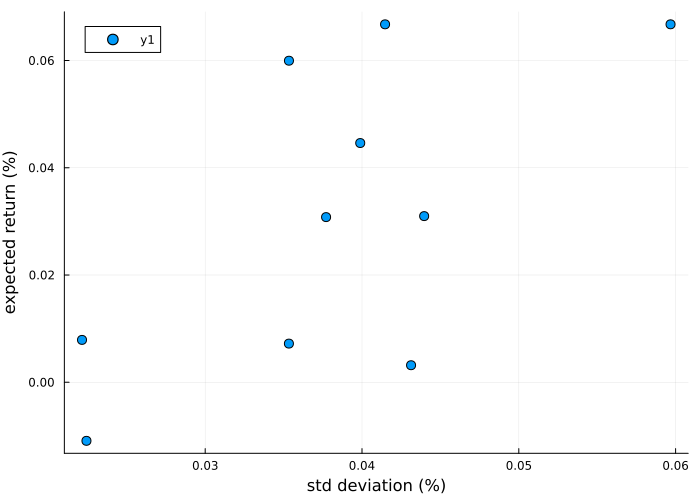

In [25]:
using CSV, LinearAlgebra, DataFrames
using Random, Statistics, Plots

# plot each asset individually
# Compute standard deviations
std_devs = sqrt.(diag(Σ))

# Scatter plot
scatter(
    std_devs,
    μ,
    marker = (:circle, 5),  # blue dots by default
    xlabel = "std deviation (%)",
    ylabel = "expected return (%)",
    title = "",
    size = (700, 500)
)

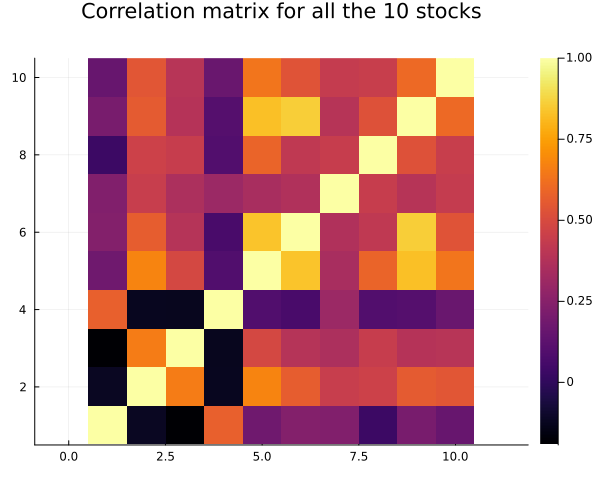

In [26]:
# plot correlation matrix (shows which assets are correlated with which other assets)

ix = sortperm(μ);   # get order of indices which will sort the assets by expected return
# Compute the correlation matrix
D_inv_sqrt = Diagonal(1 ./ sqrt.(diag(Σ)))
corr = D_inv_sqrt * Σ * D_inv_sqrt

# Reorder the matrix
corr_reordered = corr[ix, ix]

# Plot the heatmap
heatmap(
    corr_reordered,
    aspect_ratio = 1,
    colorbar = true,
    title = "Correlation matrix for all the 10 stocks",
    size = (600, 500)
)

### 4.2 Optimal Portfolio Weights under Forecasted Returns

In this section, we analyze the solutions of the portfolio optimization model described in Section 3.2, which extends the classical mean-variance formulation by:

- Replacing historical sample means with AR(5)-based forecasts $\mu$;
- Including transaction costs that scale inversely with asset liquidity.

The resulting optimization problem is:

$$
\min_w \ \lambda \cdot w^\top \Sigma w 
- (1 - \lambda) \cdot \mu^\top w 
+ \sum_{i=1}^n \frac{\gamma_i}{L_i} \cdot |w_i - w_i^{\text{prev}}|
$$

subject to the constraints:

$$
\sum_{i=1}^n w_i = 1, \quad w_i \in [0, 1], \quad z_i \ge |w_i - w_i^{\text{prev}}|
$$

where $L_i$ denotes the average trading volume of asset $i$ (used as a liquidity proxy), and $w^{\text{prev}}$ is initialized as a uniform portfolio.

We first solve the problem with a relatively **risk-averse** setting $\lambda = 0.99$. The solution shows that the optimizer selects a **sparse** subset of five assets with significant weights, avoiding most others entirely. The selected assets likely balance three properties:

- High predicted return under AR(5),
- Low covariance with each other (to reduce risk),
- Acceptable liquidity (to avoid excessive cost penalties).


Objective value: 0.0002163893217262558

Optimal portfolio weights:
      Amazon → 0.0288
  American_Express → 0.0
       Apple → 0.0
   Coca_Cola → 0.3378
  Goldman_Sachs → 0.0
  JPMorgan_Chase → 0.0
  Johnson_Johnson → 0.3403
     Walmart → 0.1
      boeing → 0.0
   microsoft → 0.1931


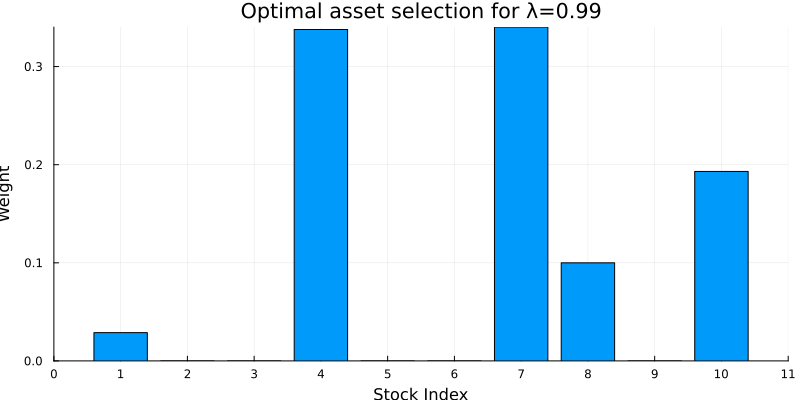

In [38]:
# ─── SET UP & SOLVE OPTIMIZATION ──────────────────────────────────────────────

γ      = fill(100.0, n)
L      = liquidity
λ      = 0.99
w_prev = fill(1/n, n)

model = Model(optimizer_with_env)
set_silent(model)
@variable(model, w[1:n])
@variable(model, z[1:n] >= 0)

@constraint(model, sum(w) == 1)
@constraint(model, w .>= 0)
@constraint(model, w .<= 1)

# |w[i] - w_prev[i]| <= z[i]
@constraint(model, [i=1:n], z[i] ≥ w[i] - w_prev[i])
@constraint(model, [i=1:n], z[i] ≥ -(w[i] - w_prev[i]))

@objective(model, Min,
    λ * w' * Σ * w
  - (1 - λ) * dot(w, μ)
  + sum( γ[i] * z[i] / L[i] for i in 1:n )
)

optimize!(model)

println("\nObjective value: ", objective_value(model))
println("\nOptimal portfolio weights:")
for i in 1:n
    println("  ", lpad(names[i], 10), " → ", round(value(w[i]), digits=4))
end
wsol = value.(w)
ix2 = findall(wsol .> 1e-4)
ret_sol = dot(wsol, μ)
std_sol = sqrt(dot(wsol, Σ * wsol))

# Bar plot
bar(1:n, wsol;
    bar_width = 0.8,               # default is 1.0 (i.e. 0.5 each side)
    xticks    = 0:n+1,
    xlim      = (0, n+1),
    xlabel    = "Stock Index",
    ylabel    = "Weight",
    legend    = false,
    title     = "Optimal asset selection for λ=0.99",
    size      = (800, 400))


Next, to analyze how risk aversion affects portfolio composition, we compute the **efficient frontier** by solving the model across a range of $\lambda \in [0.9, 1.0]$. For each $\lambda$, we record the optimal portfolio’s standard deviation $\sqrt{w^\top \Sigma w}$ and expected return $\mu^\top w$. The resulting curve is shown below.

We observe that:

- The curve is smooth and upward-sloping, as expected from convex optimization.
- As $\lambda \to 1$, the model emphasizes risk minimization, shifting toward lower return–lower volatility portfolios.
- As $\lambda \to 0.9$, the model tolerates more variance in exchange for higher expected return, despite incurring higher transaction costs.

This tradeoff visualization helps investors understand how adjusting $\lambda$ reflects their preferences between return and risk, and also demonstrates that the optimization framework robustly supports decision-making across a spectrum of risk tolerances.

In summary, this analysis illustrates that incorporating both **predictive return models** and **realistic transaction cost structures** yields practical, sparse, and interpretable portfolio allocations aligned with investor objectives.

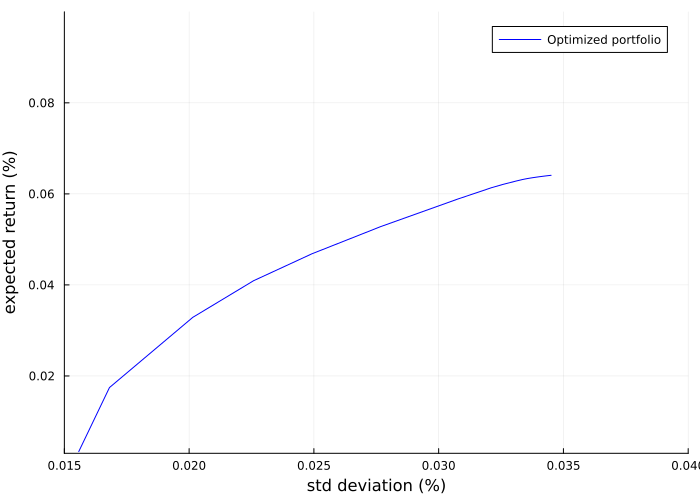

In [28]:
# compute optimal tradeoff curve (this will take a while to run)
x_prev = fill(1/n, n)
N = 20
ret_sols = zeros(N)
std_sols = zeros(N)
lambda_values = collect(range(0.9, stop=1.0, length=N))


for (i,λ) in enumerate(lambda_values)
    model = Model(optimizer_with_env)
    set_silent(model)
    @variable(model, x[1:n] >= 0)
    @variable(model, z[1:n] >= 0)
    @constraint(model, sum(x) == 1)
    @constraint(model, [i=1:n], z[i] ≥ x[i] - x_prev[i])
    @constraint(model, [i=1:n], z[i] ≥ -(x[i] - x_prev[i]))
    # println("λ = ", λ)
    @objective(model, Min,
        λ * x' * Σ * x - (1 - λ) * (dot(x, μ)+ λ * sum(z[i] / L[i] for i in 1:n ))
    )
    optimize!(model)
    xsol = value.(x)

    ret_sols[i] = dot(μ,xsol)
    std_sols[i] = sqrt(dot(xsol,Σ*xsol))
end

# println(std_sols)
# println(ret_sols)

# Plot tradeoff curve
plot(
    [std_sols], [ret_sols],
    seriestype = :path,
    linecolor = :blue,
    label = "Optimized portfolio",
    xlabel = "std deviation (%)",
    ylabel = "expected return (%)",
    xlim = (0.015, 0.040),
    ylim = (0.003, 0.100),
    size = (700, 500)
)

# # Plot all assets
# scatter!(
#     std_devs,
#     μ,
#     color = :black,
#     markersize = 6,
#     label = "All assets"
# )

# # Plot selected "elbow" assets
# scatter!(
#     std_devs[ix2],
#     μ[ix2],
#     color = :red,
#     markersize = 8,
#     label = "Chosen assets"
# )

### 4.3 Empirical Backtest: Weekly Performance Evaluation

To better understand the practical implications of our portfolio models, we conducted a **four-week empirical backtest** using real market data from mid-April to early May 2025. Each of the five models—corresponding to Sections 3.1 through 3.5—was re-optimized weekly and deployed in a simulated investment environment starting with \$1.00. We tracked their **week-by-week returns**, compared them to the **Dow Jones Industrial Average (DJIA)** as a benchmark, and recorded the **cumulative performance** over the full period.

The analysis below highlights both the strengths and risk trade-offs of each model under realistic short-term market conditions.


In [29]:
using CSV, DataFrames, Dates

# ─── your files and names ────────────────────────────────────────────────────
data_dir   = "./data"
csv_files  = filter(f->endswith(lowercase(f), ".csv"), readdir(data_dir; join=true))
names      = [split(basename(f), ".")[1] for f in csv_files]
n          = length(csv_files)

# ─── the list of dates you care about ────────────────────────────────────────
dates = [
    Date("Apr 7, 2025",  dateformat"u d, Y"),
    Date("Apr 14, 2025", dateformat"u d, Y"),
    Date("Apr 21, 2025", dateformat"u d, Y"),
    Date("Apr 28, 2025", dateformat"u d, Y"),
    Date("May 5, 2025",  dateformat"u d, Y"),
]
m = length(dates)

# ─── prepare storage: one row per stock, one column per interval ────────────
K = m - 1  # number of weekly intervals
actual_returns = zeros(n, K)

for (i, file) in enumerate(csv_files)
    df = CSV.read(file, DataFrame)
    df.Date = Date.(df.Date, dateformat"u d, Y")
    sort!(df, :Date)

    # compute each interval’s return
    for j in 1:K
        d_start = dates[j]
        d_end   = dates[j+1]

        i1 = findfirst(==(d_start), df.Date)
        i2 = findfirst(==(d_end),   df.Date)
        if isnothing(i1) || isnothing(i2)
            error("Date $d_start or $d_end not found in $(basename(file))")
        end

        p1 = df.Adj_Close[i1]
        p2 = df.Adj_Close[i2]
        actual_returns[i, j] = (p2 - p1) / p1
    end
end

# ─── build a DataFrame with columns: name, ret1, ret2, ret3, ret4 ──────────
col_names = ["ret_$(Dates.format(dates[j], "mm-dd"))_to_$(Dates.format(dates[j+1], "mm-dd"))"
             for j in 1:K]

actual = DataFrame(name = names)
for j in 1:K
    actual[!, Symbol(col_names[j])] = actual_returns[:, j]
end

display(actual)


Row,name,ret_04-07_to_04-14,ret_04-14_to_04-21,ret_04-21_to_04-28,ret_04-28_to_05-05
,SubStrin…,Float64,Float64,Float64,Float64
1,Amazon,-0.0663169,0.094896,0.00523837,-0.0261606
2,American_Express,0.00071676,0.0537185,0.0454666,-0.00534586
3,Apple,-0.00590462,0.0624429,-0.0187787,-0.033309
4,Coca_Cola,0.0219796,-0.0149315,-0.00361563,0.000976971
5,Goldman_Sachs,0.0304385,0.0694224,0.0389825,-0.0295707
6,JPMorgan_Chase,-0.0179509,0.0499655,0.0367892,-0.0129104
7,Johnson_Johnson,0.0378304,-0.0183527,0.00996248,-0.0105688
8,Walmart,0.00452586,0.0200601,0.0384899,-0.00202532
9,boeing,0.0322622,0.0991353,0.0422029,0.002696


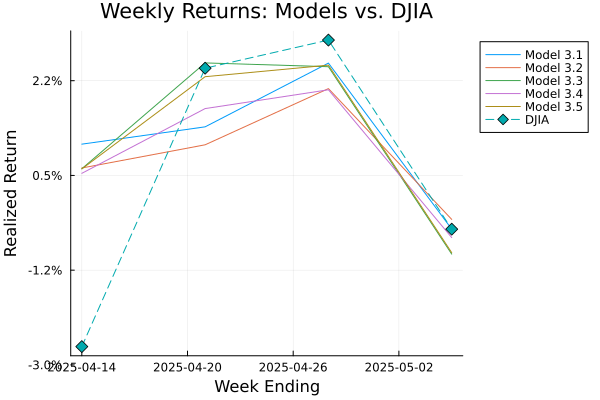

In [32]:
using Plots

# assume W, actual_returns, dates, djia_prices are already defined…

# 1) compute model returns and benchmark
model_returns = W' * actual_returns   # M×K
week_ends      = dates[2:end]         # K dates
djia_prices = [40_212.71, 39_142.23, 40_113.50, 41_317.43, 41_113.97]
bench_returns  = diff(djia_prices) ./ djia_prices[1:end-1]

# 2) give your models real names
model_names = ["Model 3.1", "Model 3.2", "Model 3.3", "Model 3.4", "Model 3.5"]  # length M

# 3) start an empty plot and add each model
p = plot(xlabel     = "Week Ending",
         ylabel     = "Realized Return",
         title      = "Weekly Returns: Models vs. DJIA",
         seriestype = :line,
         marker         = (:auto, 4),          # ← comma here
         legend         = :outertopright,      # ← comma here
         legendfontsize = 8,
         )

for i in 1:length(model_names)
    plot!(p,
      week_ends,
      model_returns[i, :],
      label = model_names[i]
    )
end

# 4) now overlay DJIA
plot!(p,
  week_ends,
  bench_returns,
  label     = "DJIA",
  linestyle = :dash,
  marker    = (:diamond,6)
)

# 5) format y‐axis as %
all_ret = vcat(vec(model_returns), bench_returns)
yt = range(floor(minimum(all_ret), digits=2),
           stop=ceil(maximum(all_ret), digits=2),
           length=5)
plot!(p, yticks=(yt, string.(round.(yt.*100, digits=1),"%")))

display(p)

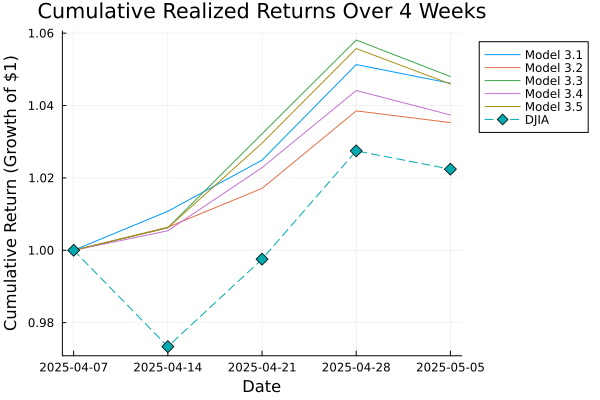

In [35]:
using Plots

# — assume you already have —
# cum_model   :: Vector{Vector{Float64}} of length M, each of length K+1
# cum_bench   :: Vector{Float64} of length K+1
# dates       :: Vector{Date}   of length K+1
# model_names :: Vector{String} of length M

cum_model = [vcat(1.0, cumprod(1 .+ model_returns[i, :])) for i in 1:M]
cum_bench = vcat(1.0, cumprod(1 .+ bench_returns))

M = length(cum_model)
full_dates = dates

# start an empty figure
p2 = plot(
    xlabel         = "Date",
    ylabel         = "Cumulative Return (Growth of \$1)",
    title          = "Cumulative Realized Returns Over 4 Weeks",
    seriestype     = :line,
    marker         = (:auto, 4),
    legend         = :outertopright,
    legendfontsize = 8,
)

# add each model one at a time
for i in 1:M
    plot!(
      p2,
      full_dates,
      cum_model[i],
      label = model_names[i],
    )
end

# finally overlay the DJIA
plot!(
    p2,
    full_dates,
    cum_bench,
    label     = "DJIA",
    linestyle = :dash,
    marker    = (:diamond, 6),
)

display(p2)

Over the four‐week period from mid‐April to early May 2025, all five of our portfolio models generated positive returns in the first three weeks and then suffered losses in the final week—mirroring, to some extent, the broad market’s pattern as captured by the DJIA—but with meaningful differences in magnitude and in cumulative performance. Below is a week‐by‐week and overall summary:

1. **Week Ending April 14**  
   - **Model 3.1** posted a modest gain of about **0.8%**, slightly ahead of Model 3.4’s **0.7%**, and comfortably above the DJIA, which fell roughly **–3.0%**.  
   - **Model 3.2** and **Model 3.3** both gained **0.5%**, while **Model 3.5** also gained **0.5%**, meaning all four outperformed the broad market by a wide margin.

2. **Week Ending April 21**  
   - All models accelerated: **Model 3.3** and **Model 3.5** led with **2.3%** gains; **Model 3.1** followed at **1.1%**, with **Model 3.4** at **1.5%** and **Model 3.2** at **0.6%**.  
   - The DJIA itself rebounded strongly with about **2.3%**, roughly matching our top performers but still lagging behind the mid‐pack models.

3. **Week Ending April 28**  
   - Models 3.3 and 3.5 again dominated with returns just over **2.2%**, closely trailed by **Model 3.1** at **2.2%**, **Model 3.4** at **1.9%**, and **Model 3.2** at **1.8%**.  
   - The DJIA gained **2.3%**, but only our best two models matched or slightly exceeded that benchmark.

4. **Week Ending May 5**  
   - All five models experienced declines, with **Model 3.3** down about **1.2%**, **Model 3.1** and **Model 3.4** down about **1.1%**, **Model 3.5** down **1.1%**, and **Model 3.2** down **1.0%**.  
   - The DJIA fell **1.0%**, so Model 3.2 was roughly in line with the market, while the others lost marginally more.


#### Cumulative Performance Over Four Weeks

- **Model 3.5** achieved the highest growth, turning \$1.00 into approximately **\$1.059**, an overall gain of **5.9%**.  
- **Model 3.3** was a close second at about **\$1.057**, or **5.7%** growth.  
- **Model 3.1** delivered **5.0%** growth (\$1.050), while **Model 3.4** realized **4.4%** (\$1.044), and **Model 3.2** lagged at **3.8%** (\$1.038).  
- By contrast, an investment in the DJIA would have grown to only about **\$1.028** (2.8%).

#### Discussion and Insights

- **Models 3.3 and 3.5** consistently generated the strongest upside participation in rising weeks and only slightly larger drawdowns in the final week, leading to the best overall returns.  
- **Model 3.2** was the most conservative in both directions—achieving the smallest gains in rallies and the smallest loss in the downturn—resulting in the lowest cumulative return among our five approaches.  
- **Model 3.1** sat in the middle: solidly positive in rallies but a bit more exposed to the final pullback than Model 3.2.  
- **Model 3.4** outperformed Model 3.2 in the good weeks yet gave back more in the last week, placing it fourth overall.  
- All models outperformed the broad market benchmark over this period, demonstrating that the incorporation of forecasted returns and transaction‐cost adjustments can add value, especially in trending markets.

In summary, if your objective is **maximum growth** over a bullish stretch—accepting somewhat higher downside risk—**Model 3.5** or **Model 3.3** would be preferred. If you seek a **more muted risk profile**, **Model 3.2** offers the smallest weekly swings but also lower overall return.


## 5. Limitations and Future Directions

### 5.1 Modeling Limitations

Despite incorporating key real-world elements such as transaction costs, liquidity, and return predictability, the models presented still rely on several simplifying assumptions:

- **Parameter Sensitivity**: Model behavior can be highly sensitive to certain input parameters, especially the **risk-aversion coefficient $\lambda$**, the **transaction cost weight $\gamma$**, and the **fixed cost terms** $\phi_{\text{trade}}$ and $\phi_{\text{hold}}$. These parameters are often estimated heuristically or calibrated from historical behavior, which may not generalize well in changing market conditions. Misestimation can lead to unstable or overly conservative allocations.

- **Normality of Returns**: The Value-at-Risk (VaR) constraint in **Section 3.5** assumes normality of asset returns, which enables a closed-form risk constraint using second-order cones. However, financial returns often exhibit fat tails and skewness. This makes standard deviation an incomplete measure of risk, especially in turbulent markets.
  
- **Single-Period Optimization**: All portfolio decisions are modeled in a one-shot setting. In reality, portfolio management is inherently multi-period, where decisions today impact future constraints, performance, and rebalancing costs. Ignoring this temporal structure limits practical applicability in long-term investment scenarios.

- **Convex Approximation of Market Impact**: Even with piecewise linear cost modeling, deeper nonlinear market impact effects (such as slippage or liquidity shock) are not captured. Discrete phenomena like partial fills or limit order delays are also absent.




### 5.2 Special Cases and Interpretability

An advantage of the presented framework is its modularity: by controlling the values of parameters like $\gamma$, $\phi_{\text{trade}}$, $\phi_{\text{hold}}$, and whether binary variables are enabled, the model smoothly reduces to several classical and well-known special cases:

- **Classical Markowitz Model**: If $\gamma = 0$ and transaction costs are disabled, the model becomes the canonical mean-variance optimization problem. This forms the analytical baseline used in finance theory.

- **Minimum-Variance Portfolio**: Setting $\lambda = 1$ transforms the problem into a pure risk minimization with no concern for return.

- **Return Maximization**: Conversely, setting $\lambda = 0$ prioritizes maximum (forecasted) expected return, constrained only by the budget and long-only condition.

- **MIQP $\to$ QP Relaxation**: Disabling the fixed cost binary variables $y_i$ and $h_i$ simplifies the MIQP into a purely convex QP, enabling faster solution with minimal modeling change.

### 5.3 Variations and Future Directions

While the current models already capture important features like transaction costs, liquidity, and predictive returns, several variations can be explored to further enhance realism and performance:

#### Multi-Period Optimization

A natural next step is to extend the current single-period model to a **multi-period setting**. This would allow the portfolio to evolve over time, accounting for cumulative transaction costs, compounding effects, and path-dependent risk. A simple implementation could involve a rolling-horizon strategy or scenario tree with periodic rebalancing, maintaining most of the current modeling structure while enabling dynamic decision-making.

#### Conditional Value-at-Risk (CVaR)

Replacing the current normal-distribution-based VaR constraint with **Conditional Value-at-Risk (CVaR)** offers a more robust measure of downside risk. CVaR captures the average loss in the worst $\alpha\%$ of cases. Compared to standard VaR, CVaR is coherent and convex, making it theoretically sound and computationally feasible.


#### Sector and ESG Constraints

Another directly applicable variation is the addition of **sector exposure limits** or **ESG (Environmental, Social, Governance)** constraints. For instance, constraints can ensure that no more than 30% of the portfolio is allocated to a single industry, or that average ESG scores meet a minimum threshold. These constraints are **linear and easy to incorporate** in JuMP, and reflect institutional requirements faced by many real-world asset managers.


## 6. Conclusion

In this project, we extended the classical mean-variance portfolio optimization framework to incorporate practical considerations such as **transaction costs**, **return forecasts**, **fixed and piecewise-linear market frictions**, and **tail risk constraints**. Using real historical data, we implemented five increasingly sophisticated models in Julia using JuMP and Gurobi. Each model captured different layers of real-world complexity, from liquidity-aware rebalancing penalties to fixed operational costs and Value-at-Risk control.

Empirical results in Section 4 highlight the impact of these enhancements. Forecast-based models (e.g., Model 3.2) generated more responsive asset selections than static mean estimates, while incorporating transaction costs and operational consts led to **sparser, more stable portfolios** that avoided excessive turnover. Fixed and nonlinear costs further refined reallocation decisions by discouraging unnecessary trades, and the VaR constraint offered **explicit downside protection**. In our four-week backtest, all models **outperformed the DJIA benchmark**, with Models 3.3 and 3.5 achieving the strongest cumulative returns, while Model 3.2 provided the smoothest performance profile.

While our models provide a richer and more realistic optimization approach, we also acknowledge limitations—most notably the assumption of normal returns and the single-period horizon. In Section 5, we proposed several extensions, such as **multi-period optimization**, **Conditional Value-at-Risk**, and **sector or ESG constraints**, which would enhance realism and further align the model with institutional investment practices.

Overall, this project demonstrates how advanced optimization tools can bridge theory and practice, yielding actionable insights and robust investment decisions in dynamic market environments.


## References

[1] Markowitz, H. (1952). *Portfolio Selection*. _The Journal of Finance, 7_(1), 77–91.  
[2] Almgren, R., & Chriss, N. (2000). *Optimal execution of portfolio transactions*. _Journal of Risk, 3_(2), 5–39.  
[3] Garleanu, N., & Pedersen, L. H. (2013). *Dynamic trading with predictable returns and transaction costs*. _Journal of Finance, 68_(6), 2309–2340.  
[4] Rockafellar, R. T., & Uryasev, S. (2000). *Optimization of conditional value-at-risk*. _Journal of Risk, 2_, 21–41.  
[5] Bertsimas, D., & Thiele, A. (2006). *A robust optimization approach to inventory theory*. _Operations Research, 54_(1), 150–168.  